## Introduction et contexte
L'objectif est de développer un système de détection de métastases ganglionnaires à partir d'images histopathologiques numérisées, en combinant une classification patch-level et une agrégation patient-level. Cette approche vise une décision finale au niveau patient, cohérente avec le raisonnement clinique.

La détection de métastases est déterminante pour le staging et la prise en charge. La variabilité morphologique, la taille des lames et la rareté des cellules tumorales rendent la tâche difficile et imposent une évaluation rigoureuse.

Le jeu de données est limité en nombre de patients, fortement déséquilibré en faveur du normal et multi-centres, avec un sous-ensemble hors-distribution (OOD). Ces contraintes motivent des choix méthodologiques prudents et une interprétation critique des performances.

Approfondissement : La formulation patch-level suivie d'une agrégation patient-level s'apparente a une logique de Multiple Instance Learning, ou l'etiquette patient est supervisee indirectement par des instances locales. Cela implique une incertitude structurelle et des erreurs corrigees uniquement par l'aggregation, ce qui doit etre integre dans l'evaluation clinique.

## Imports

In [5]:
# Standard library
import os
import random
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Optional, List, Tuple

# Scientific stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

# Image I/O
from PIL import Image

# ML / metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# Utils
from collections import Counter
from tqdm import tqdm

print("Imports OK")
print("Torch version:", torch.__version__)

Imports OK
Torch version: 2.9.1+cu128


## Config

In [6]:
@dataclass(frozen=True)
class CFG:
    # Paths
    data_dir: Path = Path("../Data")
    patches_dir: Path = Path("../Data/patches")
    lists_dir: Path = Path("../Data/dataset_lists")

    patches_train_dir: Path = Path("../Data/patches/Train")
    patches_test_dir: Path = Path("../Data/patches/Test")

    train_mapping_csv: Path = Path("../Data/dataset_lists/train_mapping.csv")
    test_mapping_csv: Path = Path("../Data/dataset_lists/test_mapping.csv")
    hospital_mapping_csv: Path = Path("../Data/dataset_lists/hospital_mapping.csv")

    output_dir = Path("./outputs")
    output_dir.mkdir(exist_ok=True, parents=True)

    # Image / model
    img_size: int = 224

    # Training
    batch_size: int = 128
    epochs: int = 3
    lr: float = 3e-4
    weight_decay: float = 1e-4
    amp: bool = True

    # DataLoader
    num_workers: int = 8
    pin_memory: bool = True
    persistent_workers: bool = True
    prefetch_factor: int = 2

    # Repro
    seed: int = 42
    val_ratio: float = 0.3

    # Déséquilibre
    use_weighted_sampler: bool = True

    # Aggregation patient-level
    agg_method: str = "topk_mean"  # "max", "topk_mean", "prop"
    topk: int = 10
    prop_threshold: float = 0.5

    # Index disque
    patch_index_cache: Path = Path("./patch_index.csv")
    rebuild_index: bool = False

CFG = CFG()
display(pd.Series(asdict(CFG)).astype(str))

data_dir                                                   ../Data
patches_dir                                        ../Data/patches
lists_dir                                    ../Data/dataset_lists
patches_train_dir                            ../Data/patches/Train
patches_test_dir                              ../Data/patches/Test
train_mapping_csv          ../Data/dataset_lists/train_mapping.csv
test_mapping_csv            ../Data/dataset_lists/test_mapping.csv
hospital_mapping_csv    ../Data/dataset_lists/hospital_mapping.csv
img_size                                                       224
batch_size                                                     128
epochs                                                           3
lr                                                          0.0003
weight_decay                                                0.0001
amp                                                           True
num_workers                                                   

## Seeds & device

In [7]:
def seed_everything(seed: int):
    """
    Fixe toutes les sources de hasard pour assurer la reproductibilité.
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Comportement déterministe (légèrement plus lent mais reproductible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(CFG.seed)

# Sélection automatique du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Seed fixé à:", CFG.seed)
print("Device utilisé:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM totale (Go):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))

Seed fixé à: 42
Device utilisé: cuda
GPU: NVIDIA L4
VRAM totale (Go): 23.57


## Description des données
Les métadonnées associent à chaque patient un label binaire et un centre hospitalier. La structuration patient-level est essentielle pour éviter les fuites d'information lorsque des patches d'un même patient apparaissent dans plusieurs ensembles.

Le dataset est exploité à deux niveaux: patient-level pour les décisions cliniques, patch-level pour l'apprentissage du signal tumoral. La présence de centres multiples introduit un risque de décalage de distribution, matérialisé par un indicateur OOD dans le test.

Approfondissement : La multiplicite des centres implique des variations de coloration, de scanner et de preparation pouvant generer un shift de distribution. L'indicateur OOD sert surtout de test de robustesse, mais il ne permet pas d'ajuster un seuil clinique fiable avec un effectif aussi faible.

## Load metadata

In [8]:
train_map = pd.read_csv(CFG.train_mapping_csv)
test_map = pd.read_csv(CFG.test_mapping_csv)
hospital_map = pd.read_csv(CFG.hospital_mapping_csv) if CFG.hospital_mapping_csv.exists() else None

print("Train mapping:", train_map.shape)
print("Test mapping:", test_map.shape)

display(train_map.head())
display(test_map.head())

Train mapping: (34, 4)
Test mapping: (20, 5)


,patient_id,pN_stage,label,center_id
0,patient_000,pN0,0,0
1,patient_001,pN0,0,0
2,patient_002,pN0,0,0
3,patient_003,pN0,0,0
4,patient_012,pN1,1,0


,patient_id,pN_stage,label,center_id,is_ood
0,patient_101,pN0,0,0,0
1,patient_103,pN0,0,0,0
2,patient_112,pN1,1,0,0
3,patient_119,pN2,1,0,0
4,patient_122,pN1,1,1,0


Les métadonnées indiquent 34 patients d'entraînement et 20 patients de test, avec un label binaire et un centre par patient. Cette granularité patient-level est indispensable pour éviter des fuites d'information et pour interpréter les résultats au niveau clinique.

Approfondissement : Avec un total de 54 patients, la variance des metriques est elevee et les intervalles de confiance sont larges. Toute difference marginale entre methodes peut relever du bruit d'echantillonnage plutot que d'un gain reel.

In [9]:
for df in [train_map, test_map]:
    df["patient_id"] = df["patient_id"].astype(str)
    df["center_id"] = df["center_id"].astype(int)
    df["label"] = df["label"].astype(int)

In [10]:
assert train_map.groupby("patient_id")["label"].nunique().max() == 1
assert test_map.groupby("patient_id")["label"].nunique().max() == 1
print("OK: un seul label par patient")

OK: un seul label par patient


L'unicité du label par patient confirme la cohérence des annotations. Sans cette garantie, l'apprentissage supervisé serait intrinsèquement ambigu.

Approfondissement : La coherence intra-patient des labels limite le bruit supervise. Elle ne garantit pas l'absence d'erreurs d'annotation, mais elle evite une contradiction structurelle qui rendrait l'apprentissage ininterpretable.

In [11]:
assert train_map.groupby("patient_id")["center_id"].nunique().max() == 1
assert test_map.groupby("patient_id")["center_id"].nunique().max() == 1
print("OK: un seul center par patient")

OK: un seul center par patient


Le fait qu'un patient appartienne à un seul centre simplifie l'analyse inter-centres et limite un mélange de distributions qui pourrait biaiser l'évaluation.

Approfondissement : Un seul centre par patient simplifie l'analyse inter-centres, mais n'empeche pas l'apprentissage de signatures specifiques au site. Ce point est critique pour la generalisation et pour l'analyse ID/OOD.

In [12]:
print("Distribution OOD (test):")
display(test_map["is_ood"].value_counts())

Distribution OOD (test):


is_ood
0    16
1     4
Name: count, dtype: int64

La distribution OOD du test (16 ID, 4 OOD) montre un sous-ensemble hors-distribution réduit. Les conclusions sur la robustesse inter-centres devront donc rester prudentes.

Approfondissement : Quatre patients OOD ne permettent pas de conclure solidement sur la robustesse hors-distribution. Un ou deux cas atypiques peuvent renverser les metriques, d'ou la necessite d'une validation multi-centres plus large.

## Prétraitement et construction des datasets
La préparation consiste à indexer les patches disponibles, vérifier l'intégrité (doublons, cohérence patient-centre) et constituer un tableau patch-level exploitable. Cette étape conditionne la fiabilité des analyses ultérieures.

Approfondissement : L'indexation des patches constitue une etape de selection qui peut introduire un biais (sur- ou sous-representation de zones tumorales). Sans controle de qualite explicite, des artefacts peuvent contaminer l'apprentissage.

## Patch index (TRAIN)

In [13]:
def list_pngs(folder: Path):
    if not folder.exists():
        return []
    return sorted([p for p in folder.glob("*.png") if p.is_file()])


def build_train_patch_index(train_map: pd.DataFrame, train_patches_dir: Path) -> pd.DataFrame:
    train_patches_dir = Path(train_patches_dir)

    rows = []
    missing_patients = []
    missing_dirs = 0

    for _, r in train_map.iterrows():
        pid = str(r["patient_id"])
        center = int(r["center_id"])

        patient_dir = train_patches_dir / pid
        cancer_dir = patient_dir / "cancer"
        normal_dir = patient_dir / "normal"

        # Si le dossier patient n'existe pas, on le trace
        if not patient_dir.exists():
            missing_dirs += 1

        cancer_patches = list_pngs(cancer_dir)
        normal_patches = list_pngs(normal_dir)

        if (len(cancer_patches) + len(normal_patches)) == 0:
            missing_patients.append(pid)
            continue

        for p in cancer_patches:
            rows.append({"path": str(p), "patient_id": pid, "center_id": center, "y": 1})

        for p in normal_patches:
            rows.append({"path": str(p), "patient_id": pid, "center_id": center, "y": 0})

    df = pd.DataFrame(rows)
    print("Root train patches:", train_patches_dir.resolve())
    print("Patients sans patch sur disque:", len(missing_patients))
    print("Patients dont le dossier est manquant:", missing_dirs)
    return df

In [14]:
# =========================
# FIX STRUCTURE — CREATE CANCER DIR ONLY
# =========================

from pathlib import Path

def ensure_cancer_dir_in_train(train_root_dir: Path, verbose: bool = True):
    """
    Pour chaque patient déjà présent dans train_root_dir,
    crée le dossier 'cancer/' s'il n'existe pas.

    Structure attendue:
      train_root_dir / patient_xxx / cancer
    """
    train_root_dir = Path(train_root_dir)

    if not train_root_dir.exists():
        raise FileNotFoundError(f"Train directory not found: {train_root_dir}")

    created = 0
    checked = 0

    for patient_dir in train_root_dir.iterdir():
        if not patient_dir.is_dir():
            continue

        checked += 1
        cancer_dir = patient_dir / "cancer"

        if not cancer_dir.exists():
            cancer_dir.mkdir()
            created += 1
            if verbose:
                print(f"Created: {cancer_dir}")

    print(f"[DONE] Patients checked: {checked} | cancer/ created: {created}")

ensure_cancer_dir_in_train(CFG.patches_train_dir)

[DONE] Patients checked: 34 | cancer/ created: 0


Le contrôle de structure confirme que l'arborescence des patches est conforme, ce qui réduit le risque d'erreurs d'indexation ou de classes manquantes.

Approfondissement : La validation de la structure du stockage diminue le risque d'erreurs techniques, mais elle ne renseigne pas sur la qualite histologique des patches. Un controle de qualite visuel ou automatique reste indispensable.

In [15]:
def load_csv_safe(path: Path) -> pd.DataFrame | None:
    if not path.exists():
        return None
    try:
        df = pd.read_csv(path)
        if df.empty:
            return None
        return df
    except pd.errors.EmptyDataError:
        return None


patch_index = None
if not CFG.rebuild_index:
    patch_index = load_csv_safe(CFG.patch_index_cache)

if patch_index is None:
    patch_index = build_train_patch_index(train_map, CFG.patches_train_dir)
    patch_index.to_csv(CFG.patch_index_cache, index=False)
    print("Patch index reconstruit et sauvegardé en CSV")

print("Patch index shape:", patch_index.shape)
display(patch_index.head())

Patch index shape: (266496, 4)


,path,patient_id,center_id,y
0,../Data/patches/Train/patient_000/normal/patie...,patient_000,0,0
1,../Data/patches/Train/patient_000/normal/patie...,patient_000,0,0
2,../Data/patches/Train/patient_000/normal/patie...,patient_000,0,0
3,../Data/patches/Train/patient_000/normal/patie...,patient_000,0,0
4,../Data/patches/Train/patient_000/normal/patie...,patient_000,0,0


L'indexation recense 266 496 patches, ce qui donne une volumétrie patch-level importante malgré un effectif patient-level restreint. Cette dissociation impose d'évaluer prioritairement la généralisation au niveau patient.

Approfondissement : Le volume patch-level ne doit pas etre confondu avec un grand effectif statistique. Les patches d'un meme patient sont correles, ce qui reduit l'effectif effectif et explique la fragilite des metriques patient-level.

In [16]:
# 1) Aucun chemin dupliqué
assert patch_index["path"].duplicated().sum() == 0
print("OK: pas de patch dupliqué")

# 2) Patients indexés
print("Patients indexés:", patch_index["patient_id"].nunique())
print("Patients dans train_mapping:", train_map["patient_id"].nunique())

# 3) Distribution patch-level
display(patch_index["y"].value_counts())

OK: pas de patch dupliqué
Patients indexés: 34
Patients dans train_mapping: 34


y
0    261541
1      4955
Name: count, dtype: int64

L'absence de doublons sécurise l'intégrité des données. La distribution (261 541 patches normaux contre 4 955 tumoraux) confirme un déséquilibre extrême, susceptible de biaiser l'optimisation et la calibration.

Approfondissement : Un desequilibre aussi extreme deforme la loss et favorise des solutions triviales. Il impose d'evaluer separement la discrimination et la calibration, car une bonne separation ne garantit pas des probabilites interpretable.

## EDA patch-level (sanity, volumes, déséquilibre)

In [17]:
total_patches = len(patch_index)
n_cancer = (patch_index["y"] == 1).sum()
n_normal = (patch_index["y"] == 0).sum()

print(f"Total patches: {total_patches}")
print(f"Cancer patches: {n_cancer} ({n_cancer/total_patches:.2%})")
print(f"Normal patches: {n_normal} ({n_normal/total_patches:.2%})")

Total patches: 266496
Cancer patches: 4955 (1.86%)
Normal patches: 261541 (98.14%)


Le taux de patches tumoraux est de 1,86%, ce qui place le problème dans un régime de classe rare. Dans ce contexte, la PR-AUC et la spécificité sont plus informatives que l'accuracy brute.

Approfondissement : Avec une prevalence de 1,86 %, la PR-AUC d'un classifieur aleatoire est proche de 0,0186. Des PR-AUC modestes peuvent donc etre au-dessus du hasard sans etre cliniquement utiles.

Approfondissement : La ROC-AUC reste peu sensible a la prevalence et peut paraitre correcte malgre une precision faible. Dans ce contexte, la PR-AUC et la specificite sont plus representatifs de l'utilite clinique.

In [18]:
patches_per_patient = (
    patch_index
    .groupby("patient_id")
    .size()
    .rename("n_patches")
    .sort_values(ascending=False)
)

display(patches_per_patient.describe())

count       34.000000
mean      7838.117647
std       2696.659693
min       3264.000000
25%       5918.250000
50%       8006.500000
75%       9696.250000
max      13573.000000
Name: n_patches, dtype: float64

Le nombre de patches par patient varie fortement (3 264 à 13 573, moyenne ~7 838). Cette hétérogénéité peut biaiser les agrégations si elles ne sont pas normalisées par le nombre de patches.

Approfondissement : La variabilite du nombre de patches introduit une ponderation implicite par patient, car certains contribuent plus a l'optimisation. Cela peut biaiser l'apprentissage et les aggregations si aucune normalisation n'est appliquee.

In [19]:
cancer_ratio_per_patient = (
    patch_index
    .groupby("patient_id")["y"]
    .mean()
    .rename("cancer_ratio")
)

display(cancer_ratio_per_patient.describe())

count    34.000000
mean      0.018242
std       0.048820
min       0.000000
25%       0.000000
50%       0.000000
75%       0.012263
max       0.270169
Name: cancer_ratio, dtype: float64

La médiane du ratio tumoral est nulle et la moyenne reste à 1,8%, avec un maximum autour de 27%. Cela montre que quelques patients concentrent l'essentiel du signal tumoral.

Approfondissement : La distribution proche de zero correspond a un regime rare-event et zero-inflated. Elle rend les seuils instables et les metriques sensibles a quelques patients tres positifs.

In [20]:
patches_per_center = (
    patch_index
    .groupby("center_id")
    .size()
    .rename("n_patches")
)

display(patches_per_center)

center_id
0    35955
1    73267
2    89232
4    68042
Name: n_patches, dtype: int64

Les volumes diffèrent notablement entre centres (~36 000 à 89 000 patches). Cette hétérogénéité peut induire un apprentissage dominé par certains sites et affecter la transférabilité.

Approfondissement : Un centre sur-represente peut dominer le gradient et induire un modele specialise sur son style. Des strategies de re-pond eration ou d'echantillonnage par centre seraient necessaires pour limiter ce biais.

In [21]:
cancer_ratio_per_center = (
    patch_index
    .groupby("center_id")["y"]
    .mean()
    .rename("cancer_ratio")
)

display(cancer_ratio_per_center)

center_id
0    0.019024
1    0.005446
2    0.009268
4    0.044752
Name: cancer_ratio, dtype: float64

Les ratios tumoraux varient fortement selon les centres (~0,5% à 4,5%). Cette disparité indique un possible shift de prévalence ou de protocole, facteur de biais majeur.

Approfondissement : Des differences de prevalence entre centres deplacent les seuils optimaux et modifient directement PPV/NPV. Cela complique la calibration d'un seuil global.

In [22]:
patient_patch_summary = (
    patch_index
    .groupby("patient_id")["y"]
    .agg(
        n_patches="count",
        n_cancer="sum",
        cancer_ratio="mean"
    )
    .reset_index()
)

display(patient_patch_summary)

,patient_id,n_patches,n_cancer,cancer_ratio
0,patient_000,3264,0,0.000000
1,patient_001,3891,0,0.000000
2,patient_002,5879,0,0.000000
3,patient_003,5511,0,0.000000
4,patient_012,3838,265,0.069046
5,patient_015,3366,158,0.046940
6,patient_016,5918,1,0.000169
7,patient_017,4288,260,0.060634
8,patient_020,9095,105,0.011545
9,patient_021,8498,2,0.000235


Le tableau patient-level met en évidence des profils très hétérogènes, avec de nombreux patients sans patch tumoral. Une analyse des erreurs par patient est donc nécessaire pour interpréter les performances.

Approfondissement : L'heterogeneite patient-level implique que quelques cas atypiques peuvent dominer les metriques globales. Une analyse d'erreurs par patient est indispensable pour comprendre les modes de defaillance.

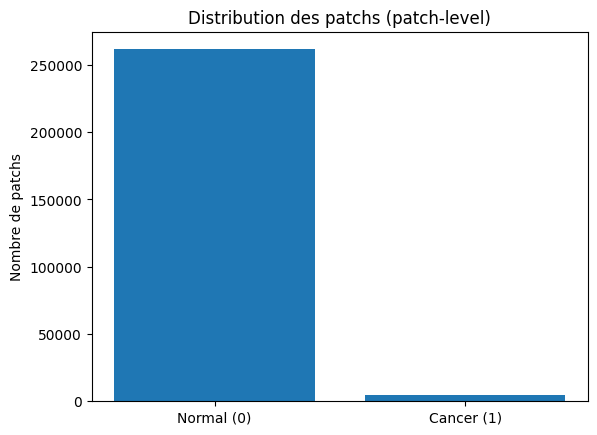

In [23]:
counts = patch_index["y"].value_counts().sort_index()
labels = ["Normal (0)", "Cancer (1)"]

plt.figure()
plt.bar(labels, counts.values)
plt.title("Distribution des patchs (patch-level)")
plt.ylabel("Nombre de patchs")
plt.show()

La visualisation confirme l'écrasante majorité de patches normaux, cohérente avec les chiffres précédents.

Approfondissement : En desequilibre extreme, l'accuracy et meme la ROC-AUC peuvent masquer une precision clinique faible. La PR-AUC et le taux de faux positifs restent plus informatifs.

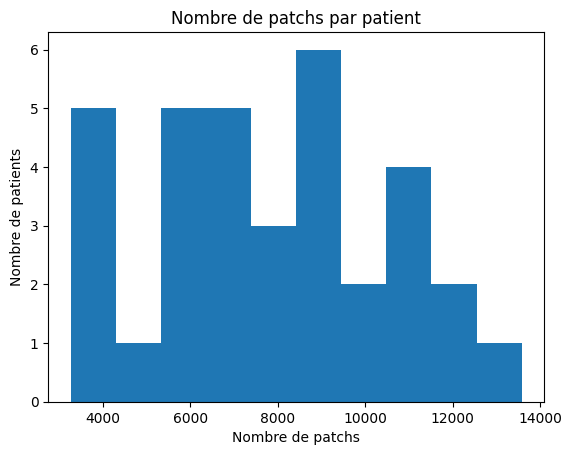

In [24]:
plt.figure()
plt.hist(patches_per_patient.values, bins=10)
plt.title("Nombre de patchs par patient")
plt.xlabel("Nombre de patchs")
plt.ylabel("Nombre de patients")
plt.show()

L'histogramme illustre la dispersion du nombre de patches par patient, ce qui peut amplifier l'influence de certains patients lors de l'entraînement.

Approfondissement : Les patients avec beaucoup de patches contribuent davantage aux gradients, ce qui peut induire un sur-ajustement a leurs caracteristiques morphologiques.

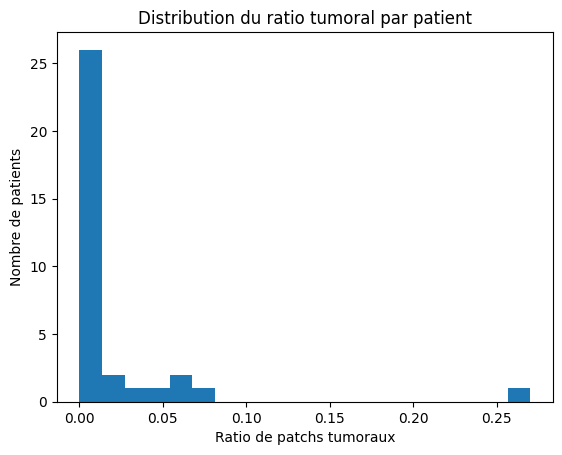

In [25]:
plt.figure()
plt.hist(cancer_ratio_per_patient.values, bins=20)
plt.title("Distribution du ratio tumoral par patient")
plt.xlabel("Ratio de patchs tumoraux")
plt.ylabel("Nombre de patients")
plt.show()

La distribution du ratio tumoral est fortement asymétrique et concentrée près de zéro, ce qui rend la tâche particulièrement difficile et pénalise la précision.

Approfondissement : Une distribution aussi asymetrique accroît la probabilite de faux positifs isoles. Cela rend les strategies d'aggregation robustes au bruit indispensables.

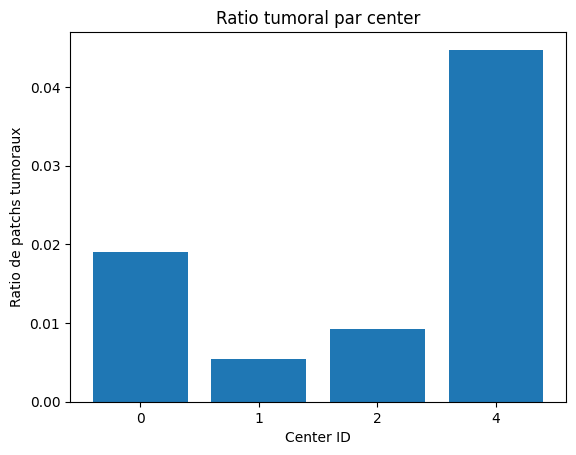

In [26]:
plt.figure()
plt.bar(
    cancer_ratio_per_center.index.astype(str),
    cancer_ratio_per_center.values
)
plt.title("Ratio tumoral par center")
plt.xlabel("Center ID")
plt.ylabel("Ratio de patchs tumoraux")
plt.show()

La variation inter-centres du ratio tumoral est visible, ce qui justifie une évaluation séparée par centre et une prudence sur la généralisation.

Approfondissement : L'effet centre est un proxy de generalisation hors-distribution. Des performances homogenes par centre seraient necessaires pour une fiabilite clinique.

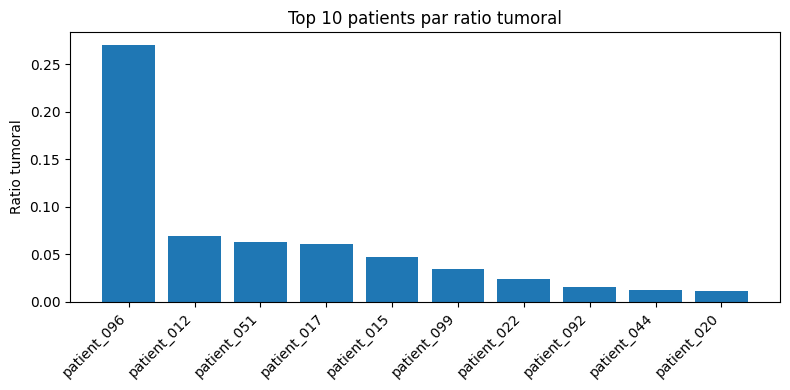

In [27]:
top_patients = (
    patient_patch_summary
    .sort_values("cancer_ratio", ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
plt.bar(top_patients["patient_id"], top_patients["cancer_ratio"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 patients par ratio tumoral")
plt.ylabel("Ratio tumoral")
plt.tight_layout()
plt.show()

Quelques patients présentent des ratios tumoraux très élevés et peuvent dominer le signal positif. Cela augmente le risque de surapprentissage sur des morphologies spécifiques.

Approfondissement : Les cas a forte charge tumorale sont plus faciles et peuvent biaiser l'apprentissage. Le risque principal est une sous-performance sur les micro-metastases, cliniquement critiques.

### Séparation Train / Validation / Test et holdout patient-level
La séparation est réalisée au niveau patient avec stratification sur le label afin d'éviter tout leakage. Cette logique de holdout patient-level est indispensable pour une estimation réaliste de la généralisation.

Approfondissement : Le split par patient est correct, mais il reste un estimateur a forte variance. Une validation croisee groupee par patient fournirait des metriques plus stables.

## Split strict par patient (train / validation, zéro leakage)

In [28]:
# Table patient-level minimale pour le split
patients_df = train_map[["patient_id", "label"]].copy()

print("Patients total:", patients_df.shape[0])
display(patients_df["label"].value_counts())

Patients total: 34


label
0    17
1    17
Name: count, dtype: int64

La balance patient-level est exactement équilibrée (17 positifs, 17 négatifs), ce qui favorise une séparation stratifiée. Cette balance ne doit toutefois pas être interprétée comme la prévalence réelle en clinique.

Approfondissement : L'equilibre patient-level facilite les metriques de ranking, mais il ne refle te pas la prevalence clinique. Les valeurs de precision predictive en pratique peuvent etre bien plus faibles.

In [29]:
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=CFG.val_ratio,
    random_state=CFG.seed
)

train_idx, val_idx = next(
    sss.split(patients_df["patient_id"], patients_df["label"])
)

train_patients = patients_df.iloc[train_idx]["patient_id"].tolist()
val_patients = patients_df.iloc[val_idx]["patient_id"].tolist()

print("Train patients:", len(train_patients))
print("Val patients:", len(val_patients))

Train patients: 23
Val patients: 11


Le split produit 23 patients en train et 11 en validation. La taille réduite du set de validation rend les métriques sensibles à un petit nombre de cas.

Approfondissement : Avec 11 patients en validation, une seule erreur peut faire varier la sensibilite ou la specificite d'environ 9 points. Des intervalles de confiance seraient necessaires pour comparer les methodes.

In [30]:
# 1) Aucun patient en commun
assert set(train_patients).isdisjoint(set(val_patients))
print("OK: aucun patient partagé entre train et val")

# 2) Distribution des labels patient
print("Train label distribution:")
display(patients_df.loc[patients_df["patient_id"].isin(train_patients), "label"].value_counts())

print("Val label distribution:")
display(patients_df.loc[patients_df["patient_id"].isin(val_patients), "label"].value_counts())

OK: aucun patient partagé entre train et val
Train label distribution:


label
1    12
0    11
Name: count, dtype: int64

Val label distribution:


label
0    6
1    5
Name: count, dtype: int64

La stratification conserve un équilibre proche entre classes et l'absence de patients partagés confirme l'absence de fuite d'information. C'est une condition indispensable pour interpréter les résultats.

Approfondissement : L'absence de leakage est necessaire mais insuffisante. La correlation intra-centre peut encore induire un sur-ajustement si les styles d'acquisition dominent le signal.

In [31]:
train_patch_index = patch_index[patch_index["patient_id"].isin(train_patients)].reset_index(drop=True)
val_patch_index = patch_index[patch_index["patient_id"].isin(val_patients)].reset_index(drop=True)

print("Train patches:", train_patch_index.shape[0])
print("Val patches:", val_patch_index.shape[0])

Train patches: 176160
Val patches: 90336


Le volume patch-level en validation (90 336) est important, mais il repose sur seulement 11 patients. Les métriques peuvent donc être influencées par quelques individus.

Approfondissement : Les 90 336 patches ne constituent pas 90 336 observations independantes. L'unite statistique pertinente reste le patient, ce qui limite la significativite des tests.

In [32]:
# Vérifier l'absence totale de leakage
assert set(train_patch_index["patient_id"]).isdisjoint(set(val_patch_index["patient_id"]))
print("OK: zéro fuite patch-level")

# Distribution patch-level (déséquilibre attendu)
print("Train patch-level distribution:")
display(train_patch_index["y"].value_counts())

print("Val patch-level distribution:")
display(val_patch_index["y"].value_counts())

OK: zéro fuite patch-level
Train patch-level distribution:


y
0    172004
1      4156
Name: count, dtype: int64

Val patch-level distribution:


y
0    89537
1      799
Name: count, dtype: int64

Le déséquilibre patch-level reste prononcé en train et validation (~2-5% de patches tumoraux). L'apprentissage et l'évaluation doivent tenir compte de cette rareté.

Approfondissement : La PR-AUC doit etre comparee a la baseline de prevalence (2-5 %). Un gain marginal au-dessus de cette baseline peut rester insuffisant pour un triage fiable.

### Construction des jeux patch-level
Les patches sont mis en forme via des transformations standardisées compatibles avec un backbone pré-entraîné. Cette homogénéisation facilite l'apprentissage mais impose une attention particulière à la perte potentielle de détails fins.

Approfondissement : Les transformations standardisees n'adressent pas entierement la variabilite de coloration et de scanner. Sans normalisation colorimetrique, le shift inter-centres peut persister.

## Dataset PyTorch (patch-level)

In [33]:
# Transforms ImageNet (compatibles ResNet18 pré-entraîné)
train_transforms = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transforms = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

In [34]:
class PatchDataset(Dataset):
    def __init__(self, patch_index: pd.DataFrame, transforms=None):
        self.df = patch_index.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        y = int(row["y"])

        # Ouverture image
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, y

In [35]:
train_dataset = PatchDataset(
    patch_index=train_patch_index,
    transforms=train_transforms,
)

val_dataset = PatchDataset(
    patch_index=val_patch_index,
    transforms=val_transforms,
)

print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))

Train dataset size: 176160
Val dataset size: 90336


Les tailles de dataset concordent avec l'indexation et confirment le volume traité. Cela favorise la stabilité statistique au niveau patch, mais pas nécessairement au niveau patient.

Approfondissement : Un volume patch-level eleve stabilise l'optimisation mais ne reduit pas la variance patient-level. Les decisions cliniques doivent donc etre evaluees au niveau patient.

In [36]:
x, y = train_dataset[0]
print("Image shape:", x.shape)
print("Label:", y)

Image shape: torch.Size([3, 224, 224])
Label: 0


La taille 224×224 correspond aux exigences de ResNet18 et assure une normalisation uniforme. Elle peut toutefois réduire des détails histologiques fins, ce qui peut limiter la performance.

Approfondissement : Un patch 224x224 capture un contexte local limite. Des informations multi-echelles sont souvent necessaires pour juger d'un statut tumoral global.

### Gestion du déséquilibre de classes
Le déséquilibre extrême entre patches normaux et tumoraux nécessite un échantillonnage pondéré. Cette stratégie vise à exposer le modèle à un signal tumoral suffisamment fréquent pour apprendre, tout en sachant qu'elle modifie la prévalence observée pendant l'entraînement.

Approfondissement : La repond eration change l'a priori de classe vu par le modele, ce qui deplace les probabilites a posteriori. Une calibration post-hoc (Platt ou isotonic) serait necessaire pour des scores interpretable.

## DataLoader + gestion du déséquilibre (WeightedRandomSampler)

In [37]:
# Comptage par classe (train)
class_counts = train_patch_index["y"].value_counts().sort_index()
print("Train class counts:\n", class_counts)

# Poids par classe: inverse de la fréquence
class_weights = 1.0 / class_counts
print("Class weights:\n", class_weights)

# Poids par échantillon (patch)
sample_weights = train_patch_index["y"].map(class_weights).values
sample_weights = torch.as_tensor(sample_weights, dtype=torch.double)

Train class counts:
 y
0    172004
1      4156
Name: count, dtype: int64
Class weights:
 y
0    0.000006
1    0.000241
Name: count, dtype: float64


Les poids appliqués amplifient la contribution des patches tumoraux d'environ un facteur 40. Cette correction est nécessaire pour apprendre la classe rare, mais modifie la distribution effective vue par le modèle.

Approfondissement : Le facteur 40 reequilibre l'apprentissage mais augmente la sensibilite aux faux positifs. Cela peut expliquer une PR-AUC faible malgre une ROC-AUC correcte.

#### 0.000241 / 0.000006 ~ 40
Un patch cancer a ~40 fois plus de chances d’être tiré qu’un patch normal.

Approfondissement : L'echantillonnage pond ere produit des batchs quasi equilibres, utiles pour l'optimisation, mais non representatifs de la prevalence reelle. Les seuils doivent donc etre recalibres sur la distribution clinique.

In [38]:
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [39]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    sampler=train_sampler if CFG.use_weighted_sampler else None,
    shuffle=False,  # IMPORTANT: pas de shuffle quand sampler est utilisé
    num_workers=CFG.num_workers,
    pin_memory=CFG.pin_memory,
    persistent_workers=CFG.persistent_workers,
    prefetch_factor=CFG.prefetch_factor,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    pin_memory=CFG.pin_memory,
    persistent_workers=CFG.persistent_workers,
    prefetch_factor=CFG.prefetch_factor,
)

In [40]:
def inspect_loader(loader, n_batches=20):
    counts = Counter()
    it = iter(loader)
    for _ in range(n_batches):
        _, y = next(it)
        counts.update(y.tolist())
    return counts

inspect_loader(train_loader)

Counter({0: 1289, 1: 1271})

Les mini-batchs deviennent quasi équilibrés entre classes, ce qui améliore la stabilité de l'optimisation. En contrepartie, la calibration des probabilités peut être biaisée par cette repondération.

Approfondissement : Le passage d'une distribution d'entraînement reponderee a une distribution reelle desequilibree peut deformer la calibration. Sans correction, un seuil fixe peut generer un exces de positifs.

## Architecture du modèle
Le modèle utilisé est un CNN de type ResNet18 pré-entraîné sur ImageNet, adapté à une classification binaire. Ce choix privilégie la simplicité, la reproductibilité et la stabilité dans un contexte de dataset limité et de contraintes hardware.

Un backbone léger limite le risque de surapprentissage excessif et sert de baseline solide avant d'envisager des architectures plus complexes.

Approfondissement : Le transfert ImageNet apporte des filtres generiques, mais l'histopathologie differe fortement des images naturelles. Un fine-tuning complet peut etre necessaire, au risque d'overfitting avec peu de patients.

## Modèle CNN (ResNet18) + loss + optimiseur

In [41]:
# Charger ResNet18 pré-entraîné
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Remplacer la tête de classification
# ResNet18 sort un vecteur de 512 features
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: normal / cancer

model = model.to(device)

In [42]:
criterion = nn.CrossEntropyLoss()

In [43]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
)

In [44]:
scaler = torch.amp.GradScaler('cuda',enabled=CFG.amp)

In [45]:
# Test forward pass
x, y = next(iter(train_loader))
x = x.to(device)

with torch.no_grad():
    out = model(x)

print("Input batch shape:", x.shape)
print("Output logits shape:", out.shape)

Input batch shape: torch.Size([128, 3, 224, 224])
Output logits shape: torch.Size([128, 2])


Le passage avant valide la cohérence des dimensions d'entrée et de sortie, ce qui réduit le risque d'erreurs silencieuses avant l'entraînement.

Approfondissement : Ce controle technique evite des erreurs de pipeline, mais ne garantit pas la stabilite de l'apprentissage ni la qualite des representations apprises.

## Entraînement du modèle
L'entraînement optimise une loss de classification binaire avec AdamW et un pas d'apprentissage modéré, en s'appuyant sur un échantillonnage pondéré pour atténuer le déséquilibre. Les métriques principales sont ROC-AUC et PR-AUC, cette dernière étant plus informative en présence de classes rares.

La phase d'entraînement est centrale pour stabiliser le modèle, mais la validation doit rester la référence pour limiter l'optimisme lié au surajustement.

Approfondissement : L'optimisation avec AdamW et repond eration peut produire des scores sur-confiants. L'absence de regularisation plus riche (augmentations colorimetriques, gel partiel du backbone) peut accentuer le sur-ajustement.

## Boucle d’entraînement (train + validation)

In [46]:
def compute_patch_metrics(y_true, y_prob):
    metrics = {}
    metrics["roc_auc"] = roc_auc_score(y_true, y_prob)
    metrics["pr_auc"] = average_precision_score(y_true, y_prob)
    return metrics

In [47]:
def train_one_epoch(
    model,
    loader,
    optimizer,
    criterion,
    device,
    scaler,
):
    model.train()

    losses = []
    y_true_all = []
    y_prob_all = []

    for x, y in tqdm(loader, desc="Train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda',enabled=CFG.amp):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        probs = torch.softmax(logits, dim=1)[:, 1]
        y_true_all.extend(y.cpu().numpy())
        y_prob_all.extend(probs.detach().cpu().numpy())

    metrics = compute_patch_metrics(
        np.array(y_true_all),
        np.array(y_prob_all)
    )

    return np.mean(losses), metrics

In [48]:
@torch.no_grad()
def validate_one_epoch(
    model,
    loader,
    criterion,
    device,
):
    model.eval()

    losses = []
    y_true_all = []
    y_prob_all = []

    for x, y in tqdm(loader, desc="Val", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())

        probs = torch.softmax(logits, dim=1)[:, 1]
        y_true_all.extend(y.cpu().numpy())
        y_prob_all.extend(probs.cpu().numpy())

    metrics = compute_patch_metrics(
        np.array(y_true_all),
        np.array(y_prob_all)
    )

    return np.mean(losses), metrics

In [49]:
def positive_rate(y):
    """
    Calcule la proportion de positifs (y == 1).

    Paramètres
    ----------
    y : array-like (list, np.array, pd.Series)
        Labels binaires (0 = négatif, 1 = positif)

    Retour
    ------
    rate : float
        Proportion de positifs (entre 0 et 1)
    """
    y = np.asarray(y)
    assert set(np.unique(y)).issubset({0, 1}), "y doit être binaire (0/1)"

    return y.mean()

val_pos_rate = positive_rate(val_patch_index["y"])
print(f"Proportion de patchs cancer (val): {val_pos_rate:.4%}")

Proportion de patchs cancer (val): 0.8845%


Le taux de patches positifs en validation est inférieur à 1%, ce qui rend l'évaluation particulièrement sensible aux faux positifs. La PR-AUC est donc un indicateur clé.

Approfondissement : A prevalence <1 %, un faible taux de faux positifs suffit a degrader fortement la precision. La PR-AUC est donc l'indicateur le plus aligne avec les contraintes cliniques.

In [50]:
history = []

best_val_auc = -1.0
best_epoch = -1
best_model_path = CFG.output_dir / "best_model.pt"

for epoch in range(CFG.epochs):
    print(f"\nEpoch {epoch+1}/{CFG.epochs}")

    train_loss, train_metrics = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        scaler,
    )

    val_loss, val_metrics = validate_one_epoch(
        model,
        val_loader,
        criterion,
        device,
    )

    print(
        f"Train loss: {train_loss:.4f} | "
        f"ROC-AUC: {train_metrics['roc_auc']:.4f} | "
        f"PR-AUC: {train_metrics['pr_auc']:.4f}"
    )

    print(
        f"Val   loss: {val_loss:.4f} | "
        f"ROC-AUC: {val_metrics['roc_auc']:.4f} | "
        f"PR-AUC: {val_metrics['pr_auc']:.4f}"
    )

    # --- Sauvegarde du meilleur modèle ---
    if val_metrics["roc_auc"] > best_val_auc:
        best_val_auc = val_metrics["roc_auc"]
        best_epoch = epoch + 1

        torch.save(
            {
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "val_roc_auc": best_val_auc,
                "config": vars(CFG),
            },
            best_model_path,
        )

        print(
            f"✔ Nouveau meilleur modèle sauvegardé "
            f"(epoch {best_epoch}, val ROC-AUC = {best_val_auc:.4f})"
        )

    history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_roc_auc": train_metrics["roc_auc"],
        "train_pr_auc": train_metrics["pr_auc"],
        "val_loss": val_loss,
        "val_roc_auc": val_metrics["roc_auc"],
        "val_pr_auc": val_metrics["pr_auc"],
    })


Epoch 1/3


Train loss: 0.0815 | ROC-AUC: 0.9952 | PR-AUC: 0.9957
Val   loss: 0.1590 | ROC-AUC: 0.8302 | PR-AUC: 0.0511
✔ Nouveau meilleur modèle sauvegardé (epoch 1, val ROC-AUC = 0.8302)

Epoch 2/3


Train loss: 0.0449 | ROC-AUC: 0.9986 | PR-AUC: 0.9986
Val   loss: 0.2570 | ROC-AUC: 0.7397 | PR-AUC: 0.0207

Epoch 3/3


Train loss: 0.0342 | ROC-AUC: 0.9992 | PR-AUC: 0.9992
Val   loss: 0.1787 | ROC-AUC: 0.8082 | PR-AUC: 0.0409


Les métriques d'entraînement sont quasi parfaites (ROC-AUC ~0,995-0,999), alors que la validation reste modérée (ROC-AUC 0,74-0,83) et surtout une PR-AUC très faible (~0,02-0,05). Ce décalage suggère un surapprentissage et une calibration insuffisante face à la classe rare, limitant la confiance dans la généralisation.

Approfondissement : Un ROC-AUC eleve avec une PR-AUC tres faible traduit une capacite de ranking globale mais une incapacite a isoler correctement la classe rare. Cela signale une calibration faible et une sensibilite excessive aux faux positifs.

Approfondissement : L'ecart train/val suggere un sur-apprentissage renforce par la correlation intra-patient. Des strategies comme la validation croisee groupee, l'arret precoce ou le gel partiel du backbone pourraient att enuer ce phenomene.

### Entraînement sur 10 Epoch

Epoch 1/10
                                                          
Train loss: 0.0212 | ROC-AUC: 0.9997 | PR-AUC: 0.9996
Val   loss: 0.1314 | ROC-AUC: 0.5903 | PR-AUC: 0.0594

Epoch 2/10
                                                          
Train loss: 0.0187 | ROC-AUC: 0.9997 | PR-AUC: 0.9997
Val   loss: 0.1874 | ROC-AUC: 0.6356 | PR-AUC: 0.0336

Epoch 3/10
                                                          
Train loss: 0.0164 | ROC-AUC: 0.9998 | PR-AUC: 0.9998
Val   loss: 0.1904 | ROC-AUC: 0.7636 | PR-AUC: 0.0278

Epoch 4/10
                                                          
Train loss: 0.0148 | ROC-AUC: 0.9998 | PR-AUC: 0.9998
Val   loss: 0.2184 | ROC-AUC: 0.5990 | PR-AUC: 0.0364

Epoch 5/10
                                                          
Train loss: 0.0134 | ROC-AUC: 0.9999 | PR-AUC: 0.9998
Val   loss: 0.2466 | ROC-AUC: 0.5371 | PR-AUC: 0.0149

Epoch 6/10
                                                          
Train loss: 0.0125 | ROC-AUC: 0.9999 | PR-AUC: 0.9998
Val   loss: 0.1679 | ROC-AUC: 0.6923 | PR-AUC: 0.0147

Epoch 7/10
                                                          
Train loss: 0.0125 | ROC-AUC: 0.9999 | PR-AUC: 0.9998
Val   loss: 0.4259 | ROC-AUC: 0.4637 | PR-AUC: 0.0130

Epoch 8/10
                                                          
Train loss: 0.0109 | ROC-AUC: 0.9999 | PR-AUC: 0.9998
Val   loss: 0.1952 | ROC-AUC: 0.5343 | PR-AUC: 0.0257

Epoch 9/10
                                                          
Train loss: 0.0110 | ROC-AUC: 0.9999 | PR-AUC: 0.9999
Val   loss: 0.4998 | ROC-AUC: 0.6718 | PR-AUC: 0.0125

Epoch 10/10
Train loss: 0.0094 | ROC-AUC: 0.9999 | PR-AUC: 0.9999
Val   loss: 0.2649 | ROC-AUC: 0.7020 | PR-AUC: 0.0187

Approfondissement : Les fluctuations importantes des metriques de validation selon les epochs indiquent une forte variance due au petit effectif patient-level. L'absence de tendance stable suggere une optimisation partiellement guidee par le bruit.

Approfondissement : La selection du meilleur epoch sur un seul split augmente le risque d'overfitting a la validation. Une evaluation sur plusieurs splits patients serait plus robuste.

## Évaluation patch-level
Les performances patch-level sont évaluées sur le jeu de validation, puis les probabilités prédictives sont utilisées pour l'agrégation patient-level. Cette étape mesure la capacité à repérer des zones suspectes, sans refléter directement la décision clinique finale.

Les métriques sont interprétées avec prudence, en particulier la PR-AUC qui est sensible à la prévalence très faible des patches tumoraux.

Approfondissement : De bonnes performances patch-level peuvent etre tirees par des patches faciles (tissu normal evident) sans garantir une detection fiable des foyers tumoraux rares. Cela explique la decouplage frequent entre patch-level et patient-level.

## Inférence patch-level (VAL) puis agrégation patient-level

In [51]:
best_model_path = CFG.output_dir / "best_model.pt"
assert best_model_path.exists(), "Checkpoint introuvable. As-tu bien sauvegardé le modèle ?"

checkpoint = torch.load(
    best_model_path,
    map_location=device,
    weights_only=False
)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print(
    f"Modèle chargé depuis epoch {checkpoint['epoch']} "
    f"(val ROC-AUC = {checkpoint['val_roc_auc']:.4f})"
)

Modèle chargé depuis epoch 1 (val ROC-AUC = 0.8302)


Le meilleur modèle est retenu à l'époque 1 sur la base de la ROC-AUC validation (0,8302), ce qui souligne la fragilité de l'optimisation avec peu d'epochs et un set de validation restreint.

Approfondissement : Le choix du meilleur epoch sur la seule ROC-AUC peut privilegier un modele mal calibre pour la classe rare. Un critere mixte incluant PR-AUC ou une contrainte clinique serait plus adapte.

In [52]:
@torch.no_grad()
def predict_patches(model, loader, device):
    model.eval()

    all_probs = []
    all_y = []

    for x, y in tqdm(loader, desc="Predict patches", leave=False):
        x = x.to(device, non_blocking=True)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)[:, 1]  # proba cancer

        all_probs.append(probs.cpu().numpy())
        all_y.append(y.numpy())

    probs = np.concatenate(all_probs)
    y_true = np.concatenate(all_y)
    return y_true, probs

In [53]:
val_y_true, val_prob = predict_patches(model, val_loader, device)

assert len(val_y_true) == len(val_patch_index)
assert len(val_prob) == len(val_patch_index)

val_pred_df = val_patch_index[["patient_id", "center_id", "y"]].copy()
val_pred_df = val_pred_df.rename(columns={"y": "y_patch"})
val_pred_df["prob_cancer"] = val_prob

print("val_pred_df shape:", val_pred_df.shape)
display(val_pred_df.head())

val_pred_df shape: (90336, 4)


,patient_id,center_id,y_patch,prob_cancer
0,patient_015,0,1,0.000654
1,patient_015,0,1,0.215059
2,patient_015,0,1,0.302070
3,patient_015,0,1,0.070594
4,patient_015,0,1,0.000026


Les prédictions patch-level couvrent 90 336 patches et incluent les probabilités de cancer, nécessaires aux agrégations patient-level. La granularité fine permet d'explorer différentes stratégies, sans garantir la robustesse clinique.

Approfondissement : Les probabilites patch-level sont correlees et l'aggregation suppose implicitement une independance qui n'est pas verifiee. Une accumulation de faux positifs peut donc faussement classer un patient.

In [54]:
patient_labels = train_map.set_index("patient_id")["label"].to_dict()
val_pred_df["y_patient"] = val_pred_df["patient_id"].map(patient_labels).astype(int)

# Sanity check: chaque patient n'a qu'un label
assert val_pred_df.groupby("patient_id")["y_patient"].nunique().max() == 1

## Agrégation patient-level
Plusieurs stratégies d'agrégation sont comparées afin de convertir des scores patch-level en un score patient-level: maximum, moyenne des k meilleurs patches et proportion de patches au-dessus d'un seuil. Ces approches traduisent des hypothèses différentes sur la distribution spatiale du signal tumoral.

Approfondissement : L'aggregation par maximum privilegie la sensibilite mais est fragile aux faux positifs isoles. A l'inverse, la proportion ou la moyenne peuvent diluer un signal rare. Le top-k constitue un compromis en se concentrant sur quelques patches les plus suspects.

Approfondissement : Le choix d'aggregation est aussi un choix de modele statistique implicite. Sans calibration des scores patch-level, les approches basees sur des seuils restent instables.

In [55]:
def agg_max(probs):
    return float(np.max(probs))

def agg_topk_mean(probs, k=10):
    k = min(k, len(probs))
    return float(np.mean(np.sort(probs)[-k:]))

def agg_prop_above(probs, thr=0.5):
    return float(np.mean(probs >= thr))

def agg_quantile(probs, q=0.95):
    return float(np.quantile(probs, q))

In [56]:
def build_patient_table(df_patches, agg_method="max", topk=10, thr=0.5):
    rows = []
    for pid, g in df_patches.groupby("patient_id"):
        probs = g["prob_cancer"].values
        y_patient = int(g["y_patient"].iloc[0])

        if agg_method == "max":
            score = agg_max(probs)
        elif agg_method == "topk_mean":
            score = agg_topk_mean(probs, k=topk)
        elif agg_method == "prop":
            score = agg_prop_above(probs, thr=thr)
        else:
            raise ValueError("agg_method inconnu")

        rows.append({"patient_id": pid, "y_patient": y_patient, "score": score})

    return pd.DataFrame(rows)

def eval_patient_table(df_patient):
    y_true = df_patient["y_patient"].values
    y_score = df_patient["score"].values
    return {
        "roc_auc": roc_auc_score(y_true, y_score),
        "pr_auc": average_precision_score(y_true, y_score),
    }

## Analyse des résultats patient-level
L'évaluation patient-level examine ROC-AUC, PR-AUC et les couples sensibilité/spécificité en tenant compte du faible nombre de patients. Les résultats doivent être lus comme des tendances et non comme des performances définitives.

Approfondissement : La ROC-AUC mesure un classement independant du seuil, mais elle peut rester elevee meme si la precision clinique est faible. La PR-AUC est plus informative quand la classe positive est rare.

Approfondissement : La sensibilite elevee reduit les faux negatifs mais peut rendre le systeme inutilisable si la specificite est trop basse. Ce compromis doit etre discute en fonction du cout clinique des erreurs.

In [57]:
results = []

# 1) Max
df_max = build_patient_table(val_pred_df, agg_method="max")
m_max = eval_patient_table(df_max)
results.append({"method": "max", **m_max})

# 2) Top-k mean
for k in [5, 10, 20]:
    df_topk = build_patient_table(val_pred_df, agg_method="topk_mean", topk=k)
    m_topk = eval_patient_table(df_topk)
    results.append({"method": f"topk_mean(k={k})", **m_topk})

# 3) Proportion au-dessus d'un seuil
for thr in [0.3, 0.5, 0.7]:
    df_prop = build_patient_table(val_pred_df, agg_method="prop", thr=thr)
    m_prop = eval_patient_table(df_prop)
    results.append({"method": f"prop(thr={thr})", **m_prop})

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
display(results_df)

,method,roc_auc,pr_auc
2,topk_mean(k=10),0.933333,0.926667
3,topk_mean(k=20),0.933333,0.926667
1,topk_mean(k=5),0.900000,0.902857
6,prop(thr=0.7),0.900000,0.902857
0,max,0.866667,0.876190
4,prop(thr=0.3),0.866667,0.876190
5,prop(thr=0.5),0.866667,0.852857


Sur validation, les agrégations top-k (k=10 ou 20) atteignent ROC-AUC ~0,93 et PR-AUC ~0,93, supérieures aux approches max ou proportion. Ces scores élevés doivent toutefois être tempérés par le faible nombre de patients (n=11) et le risque d'optimisme.

Approfondissement : Sur 11 patients, un score proche de 0,93 peut provenir d'un sur-ajustement de l'aggregation et des seuils. L'incertitude est considerable, d'ou l'interet d'intervalles de confiance ou de validation croisee.

In [58]:
df_max_sorted = df_max.sort_values("score", ascending=False)
display(df_max_sorted.head(10))

,patient_id,y_patient,score
0,patient_015,1,1.000000
1,patient_021,1,1.000000
6,patient_051,1,1.000000
10,patient_083,0,0.999986
7,patient_054,0,0.999847
9,patient_080,1,0.999469
5,patient_039,1,0.999113
4,patient_035,0,0.992796
8,patient_059,0,0.978746
2,patient_023,0,0.944330


Les scores sont saturés près de 1 pour des patients positifs et négatifs, ce qui révèle une faible séparation et une calibration incertaine. Cela rend le choix d'un seuil particulièrement instable.

Approfondissement : La saturation des scores suggere une sortie logit tres extreme, souvent liee a la repond eration. Une calibration (temperature scaling) pourrait etaler la distribution et stabiliser le seuil.

## Décision patient-level des agrégations

In [59]:
def choose_threshold_for_sensitivity(y_true, y_score, target_sens=0.95):
    """
    Choisit le plus grand seuil qui atteint au moins target_sens.
    Retourne (threshold, achieved_sens, achieved_spec).
    """
    fpr, tpr, thr = roc_curve(y_true, y_score)
    idxs = np.where(tpr >= target_sens)[0]
    if len(idxs) == 0:
        # impossible d'atteindre la sensibilité cible
        best_idx = np.argmax(tpr)
        chosen = thr[best_idx]
    else:
        chosen = thr[idxs[0]]  # seuil le plus strict qui respecte la sensibilité

    y_pred = (y_score >= chosen).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return float(chosen), float(sens), float(spec)

def patient_metrics(y_true, y_score, threshold=None):
    """
    Calcule ROC-AUC, PR-AUC et, si threshold est fourni, sens/spec et confusion.
    """
    out = {
        "roc_auc": roc_auc_score(y_true, y_score),
        "pr_auc": average_precision_score(y_true, y_score),
    }

    if threshold is not None:
        y_pred = (y_score >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        out.update({
            "threshold": float(threshold),
            "sens": tp / (tp + fn) if (tp + fn) > 0 else 0.0,
            "spec": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        })
    return out

In [60]:
def build_patient_scores(df_patches, method, topk=10, thr=0.5, q=0.95):
    rows = []
    for pid, g in df_patches.groupby("patient_id"):
        probs = g["prob_cancer"].values
        y_patient = int(g["y_patient"].iloc[0])

        if method == "max":
            score = agg_max(probs)
        elif method == "topk_mean":
            score = agg_topk_mean(probs, k=topk)
        elif method == "prop":
            score = agg_prop_above(probs, thr=thr)
        elif method == "q":
            score = agg_quantile(probs, q=q)
        else:
            raise ValueError("Méthode inconnue")

        rows.append({"patient_id": pid, "y_patient": y_patient, "score": score})

    return pd.DataFrame(rows)

In [61]:
target_sens = 0.80
results = []

# MAX
df = build_patient_scores(val_pred_df, method="max")
thr, sens, spec = choose_threshold_for_sensitivity(df["y_patient"].values, df["score"].values, target_sens)
m = patient_metrics(df["y_patient"].values, df["score"].values, threshold=thr)
results.append({"method": "max", "params": "-", "n_patients": len(df), **m})

# TOP-K
for k in [5, 10, 20]:
    df = build_patient_scores(val_pred_df, method="topk_mean", topk=k)
    thr, sens, spec = choose_threshold_for_sensitivity(df["y_patient"].values, df["score"].values, target_sens)
    m = patient_metrics(df["y_patient"].values, df["score"].values, threshold=thr)
    results.append({"method": "topk_mean", "params": f"k={k}", "n_patients": len(df), **m})

# PROPORTION
for thr_p in [0.3, 0.5, 0.7]:
    df = build_patient_scores(val_pred_df, method="prop", thr=thr_p)
    thr, sens, spec = choose_threshold_for_sensitivity(df["y_patient"].values, df["score"].values, target_sens)
    m = patient_metrics(df["y_patient"].values, df["score"].values, threshold=thr)
    results.append({"method": "prop", "params": f"thr_patch={thr_p}", "n_patients": len(df), **m})

# QUANTILES
for q in [0.90, 0.95, 0.99]:
    df = build_patient_scores(val_pred_df, method="q", q=q)
    thr, sens, spec = choose_threshold_for_sensitivity(df["y_patient"].values, df["score"].values, target_sens)
    m = patient_metrics(df["y_patient"].values, df["score"].values, threshold=thr)
    results.append({"method": "quantile", "params": f"q={q}", "n_patients": len(df), **m})

results_df = pd.DataFrame(results)

# Tri: priorité ROC-AUC puis PR-AUC puis spécificité (à sensibilité fixée)
results_df = results_df.sort_values(["roc_auc", "pr_auc", "spec"], ascending=False)

display(results_df[[
    "method", "params", "roc_auc", "pr_auc",
    "threshold", "sens", "spec", "tp", "fp", "tn", "fn",
    "n_patients"
]])

,method,params,roc_auc,pr_auc,threshold,sens,spec,tp,fp,tn,fn,n_patients
2,topk_mean,k=10,0.933333,0.926667,0.988360,1.0,0.833333,5,1,5,0,11
3,topk_mean,k=20,0.933333,0.926667,0.976809,1.0,0.833333,5,1,5,0,11
1,topk_mean,k=5,0.900000,0.902857,0.998458,0.8,0.833333,4,1,5,1,11
6,prop,thr_patch=0.7,0.900000,0.902857,0.022415,0.8,0.833333,4,1,5,1,11
0,max,-,0.866667,0.876190,0.999113,1.0,0.666667,5,2,4,0,11
4,prop,thr_patch=0.3,0.866667,0.876190,0.035545,1.0,0.666667,5,2,4,0,11
8,quantile,q=0.95,0.866667,0.876190,0.072375,1.0,0.666667,5,2,4,0,11
9,quantile,q=0.99,0.866667,0.876190,0.771304,1.0,0.666667,5,2,4,0,11
5,prop,thr_patch=0.5,0.866667,0.852857,0.035354,0.8,0.833333,4,1,5,1,11
7,quantile,q=0.9,0.800000,0.844444,0.054680,0.8,0.666667,4,2,4,1,11


La recherche de seuils pour une sensibilité cible met en évidence des seuils très élevés (~0,98) pour top-k, avec sensibilité 1,0 et spécificité 0,83. Ce compromis est prometteur sur validation, mais il repose sur un échantillon très réduit et peut ne pas se transférer.

Approfondissement : Fixer une sensibilite cible impose un cout asymetrique des erreurs, generalement en faveur de la detection. Cela peut etre pertinent en oncologie, mais entraine mecaniquement une baisse de specificite.

Approfondissement : Avec un petit n, les seuils optimises sur validation sont instables et risquent de ne pas se transferer.

In [62]:
best_row = results_df.iloc[0].to_dict()
print("Meilleure agrégation (selon ROC-AUC, PR-AUC, spec @ sens cible):")
print(best_row)

Meilleure agrégation (selon ROC-AUC, PR-AUC, spec @ sens cible):
{'method': 'topk_mean', 'params': 'k=10', 'n_patients': 11, 'roc_auc': 0.9333333333333333, 'pr_auc': 0.9266666666666666, 'threshold': 0.9883600473403931, 'sens': 1.0, 'spec': 0.8333333333333334, 'tp': 5, 'fp': 1, 'tn': 5, 'fn': 0}


La méthode retenue est top-k (k=10) avec un seuil de 0,988, sur 11 patients. Cette sélection doit être vue comme un réglage exploratoire, non comme un seuil clinique définitif.

Approfondissement : Un seuil tres eleve (0,988) indique des scores polarises. Un simple decalage de calibration entre validation et test suffit alors a faire chuter la performance.

In [63]:
best_method = best_row["method"]
best_params = best_row["params"]

# Reconstruire df_patient pour la meilleure config
if best_method == "max":
    df_best = build_patient_scores(val_pred_df, method="max")
elif best_method == "topk_mean":
    k = int(best_params.split("=")[1])
    df_best = build_patient_scores(val_pred_df, method="topk_mean", topk=k)
elif best_method == "prop":
    thr_patch = float(best_params.split("=")[1])
    df_best = build_patient_scores(val_pred_df, method="prop", thr=thr_patch)
elif best_method == "quantile":
    q = float(best_params.split("=")[1])
    df_best = build_patient_scores(val_pred_df, method="q", q=q)
else:
    raise ValueError("Inattendu")

df_best = df_best.sort_values("score", ascending=False)

display(df_best)


,patient_id,y_patient,score
1,patient_021,1,1.000000
6,patient_051,1,1.000000
0,patient_015,1,1.000000
10,patient_083,0,0.997668
9,patient_080,1,0.996933
5,patient_039,1,0.988360
7,patient_054,0,0.987058
4,patient_035,0,0.978379
8,patient_059,0,0.816736
3,patient_031,0,0.785350


Le classement patient-level met en évidence la proximité des scores entre certains cas positifs et négatifs, signe d'une marge décisionnelle étroite.

Approfondissement : Une marge decisionnelle etroite signifie que des variations mineures des scores peuvent inverser la classe. En pratique, ces cas devraient etre identifies comme incertains et soumis a relecture.

## Robustesse et généralisation par centre hospitalier

In [64]:
results_center = []

best_method = "topk_mean"
best_topk = 10
best_threshold = 0.9883600473403931

for center_id in sorted(val_pred_df["center_id"].unique()):
    df_center = val_pred_df[val_pred_df["center_id"] == center_id]

    if df_center["patient_id"].nunique() < 2:
        continue  # sécurité si trop peu de patients

    df_pat = build_patient_scores(
        df_center,
        method=best_method,
        topk=best_topk,
    )

    m = patient_metrics(
        df_pat["y_patient"].values,
        df_pat["score"].values,
        threshold=best_threshold,
    )

    results_center.append({
        "center_id": center_id,
        "n_patients": len(df_pat),
        **m,
    })

results_center_df = pd.DataFrame(results_center)
display(results_center_df)

,center_id,n_patients,roc_auc,pr_auc,threshold,sens,spec,tp,fp,tn,fn
0,1,5,1.0,1.0,0.98836,1.0,1.0,2,0,3,0
1,2,3,1.0,1.0,0.98836,1.0,1.0,1,0,2,0
2,4,2,0.0,0.5,0.98836,1.0,0.0,1,1,0,0


Les performances par centre sont très variables et basées sur de petits effectifs (n=2 à 5). Le centre 4 présente un ROC-AUC nul et une spécificité nulle, signalant une instabilité marquée et un possible effet de domaine.

Approfondissement : Des performances parfaites sur de tres petits effectifs peuvent refleter un sur-ajustement a des signatures de centre. L'effondrement sur un centre est compatible avec un shift de domaine non maitrise.

## TEST — Évaluation finale

In [66]:
# =========================
# CELLULE T1 — Charger le meilleur modèle
# =========================

best_model_path = CFG.output_dir / "best_model.pt"
assert best_model_path.exists(), "Checkpoint introuvable"

checkpoint = torch.load(
    best_model_path,
    map_location=device,
    weights_only=False
)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print(
    f"Modèle chargé depuis epoch {checkpoint['epoch']} "
    f"(val ROC-AUC = {checkpoint['val_roc_auc']:.4f})"
)

best_row = results_df.iloc[0]
best_threshold = best_row["threshold"]
print("Seuil choisi pour la suite:", best_threshold)

Modèle chargé depuis epoch 1 (val ROC-AUC = 0.8302)
Seuil choisi pour la suite: 0.9883600473403931


Le seuil fixé sur validation (0,988) est conservé pour le test, ce qui respecte la séparation des ensembles mais expose à un risque de non-transférabilité.

Approfondissement : Conserver le seuil assure une evaluation honnete, mais expose la fragilite de la calibration. Si la distribution des scores change, le seuil devient inadapt e.

In [67]:
# =========================
# CELLULE T2 — Mapping Test
# =========================

test_map = pd.read_csv(CFG.test_mapping_csv)
display(test_map)

print("Nombre total de patients Test:", len(test_map))
print("Répartition par centre:")
display(test_map["center_id"].value_counts())

print("Patients OOD:")
display(test_map[test_map["is_ood"] == 1])

,patient_id,pN_stage,label,center_id,is_ood
0,patient_101,pN0,0,0,0
1,patient_103,pN0,0,0,0
2,patient_112,pN1,1,0,0
3,patient_119,pN2,1,0,0
4,patient_122,pN1,1,1,0
5,patient_125,pN0,0,1,0
6,patient_126,pN2,1,1,0
7,patient_135,pN0,0,1,0
8,patient_142,pN1,1,2,0
9,patient_145,pN2,1,2,0


Nombre total de patients Test: 20
Répartition par centre:


center_id
0    4
1    4
2    4
3    4
4    4
Name: count, dtype: int64

Patients OOD:


,patient_id,pN_stage,label,center_id,is_ood
12,patient_163,pN2,1,3,1
13,patient_165,pN1,1,3,1
14,patient_171,pN0,0,3,1
15,patient_178,pN0,0,3,1


Le test comprend 20 patients répartis équitablement sur 5 centres, avec 4 patients OOD (centre 3). Cette structure permet une analyse ID/OOD, mais l'effectif reste limité.

Approfondissement : L'analyse ID/OOD avec 4 patients reste exploratoire. Une seule erreur modifie fortement les metriques, ce qui limite toute conclusion sur la robustesse.

In [68]:
# =========================
# CELLULE T3 — Index patch-level Test
# =========================

def build_test_patch_index(patches_dir: Path, test_map: pd.DataFrame):
    rows = []
    for pid in test_map["patient_id"]:
        patient_dir = patches_dir / pid
        if not patient_dir.exists():
            print(f"[WARN] Dossier manquant pour {pid}")
            continue

        for p in patient_dir.glob("*.png"):
            rows.append({
                "patient_id": pid,
                "path": str(p),
            })

    return pd.DataFrame(rows)


test_patch_index = build_test_patch_index(
    CFG.patches_test_dir,
    test_map,
)

print("Nombre total de patches Test:", len(test_patch_index))
display(test_patch_index.head())

Nombre total de patches Test: 180639


,patient_id,path
0,patient_101,../Data/patches/Test/patient_101/patient_101_n...
1,patient_101,../Data/patches/Test/patient_101/patient_101_n...
2,patient_101,../Data/patches/Test/patient_101/patient_101_n...
3,patient_101,../Data/patches/Test/patient_101/patient_101_n...
4,patient_101,../Data/patches/Test/patient_101/patient_101_n...


Le test contient 180 639 patches, confirmant un volume patch-level conséquent. L'évaluation clinique dépend toutefois de seulement 20 patients.

Approfondissement : Le grand nombre de patches ne compense pas la faible taille patient-level. D'un point de vue statistique, la puissance reste celle de 20 observations.

In [69]:
# =========================
# CELLULE T4 — Dataset / DataLoader Test
# =========================

class PatchDatasetTest(Dataset):
    def __init__(self, patch_index: pd.DataFrame, transforms=None):
        self.df = patch_index.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row["path"]
        patient_id = row["patient_id"]

        # Image
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)

        meta = {
            "patient_id": patient_id,
            "path": img_path,
        }

        return img, meta

test_dataset = PatchDatasetTest(
    patch_index=test_patch_index,
    transforms=val_transforms,  # PAS d’augmentation
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    pin_memory=CFG.pin_memory,
)

print("Test DataLoader prêt")
print("Nombre de patchs Test:", len(test_dataset))

Test DataLoader prêt
Nombre de patchs Test: 180639


La mise en place du DataLoader confirme la capacité à traiter l'ensemble test en bloc. Cette étape sécurise le pipeline d'inférence, sans apporter d'information directe sur la performance.

Approfondissement : Cette etape valide le pipeline d'inference mais ne dit rien sur la qualite predictive. Elle est necessaire pour la reproductibilite, pas pour la performance.

In [71]:
# =========================
# CELLULE T5 — Inférence patch-level Test
# =========================

all_preds = []

model.eval()
with torch.no_grad():
    for images, meta in tqdm(test_loader, desc="Inference Test"):
        images = images.to(device)

        with torch.amp.autocast('cuda',enabled=CFG.amp):
            logits = model(images)
            probs = torch.sigmoid(logits).view(-1).cpu().numpy()

        for pid, path, score in zip(
            meta["patient_id"],
            meta["path"],
            probs,
        ):
            all_preds.append({
                "patient_id": pid,
                "path": path,
                "score": float(score),
            })
test_pred_df = pd.DataFrame(all_preds)

print("Prédictions patch-level Test:", len(test_pred_df))
display(test_pred_df.head(20))

test_pred_df.to_csv("../ML/test_predictions.csv", index=False)

Inference Test: 100%|██████████| 1412/1412 [01:30<00:00, 15.68it/s]


Prédictions patch-level Test: 180639


,patient_id,path,score
0,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.016098
1,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.992188
2,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.991211
3,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.022324
4,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.999023
5,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.008347
6,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.995605
7,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.021942
8,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.986816
9,patient_101,../Data/patches/Test/patient_101/patient_101_n...,0.046539


Les scores patch-level sur test sont très polarisés, avec de nombreuses valeurs proches de 0 ou 1. Cette saturation suggère une sur-confiance du modèle et peut compliquer la calibration.

Approfondissement : Des scores tres polarisés sont un signe de sur-confiance. Cela peut provenir du sampling pond ere ou d'une regularisation insuffisante, et fragilise la decision seuillee.

In [102]:
# =========================
# CELLULE T6 — Agrégation patient-level Test (SANS labels)
# =========================

def build_patient_scores_test(
    df_patches: pd.DataFrame,
    method: str,
    topk: int = 10,
    thr: float = 0.9,
    q: float = 0.95,
):
    rows = []

    for pid, g in df_patches.groupby("patient_id"):
        probs = g["prob_cancer"].values

        if method == "max":
            score = probs.max()

        elif method == "topk_mean":
            k = min(topk, len(probs))
            score = np.sort(probs)[-k:].mean()

        elif method == "prop":
            score = (probs >= thr).mean()

        elif method == "q":
            score = np.quantile(probs, q)

        else:
            raise ValueError(f"Méthode inconnue: {method}")

        rows.append({
            "patient_id": pid,
            "score": float(score),
            "n_patches": len(probs),
        })

    return pd.DataFrame(rows)

# Harmonisation du nom de colonne
test_pred_df = test_pred_df.rename(columns={"score": "prob_cancer"})

test_patient_scores = build_patient_scores_test(
    test_pred_df,
    method=CFG.agg_method,
    topk=CFG.topk,
)

test_patient_scores = test_patient_scores.merge(
    test_map[["patient_id", "label", "center_id", "is_ood"]],
    on="patient_id",
    how="left",
)

display(test_patient_scores)

,patient_id,score,n_patches,label,center_id,is_ood
0,patient_101,1.0,10213,0,0,0
1,patient_103,1.0,5230,0,0,0
2,patient_112,1.0,7484,1,0,0
3,patient_119,1.0,12502,1,0,0
4,patient_122,1.0,9859,1,1,0
5,patient_125,1.0,18887,0,1,0
6,patient_126,1.0,8478,1,1,0
7,patient_135,1.0,9401,0,1,0
8,patient_142,1.0,7965,1,2,0
9,patient_145,1.0,4863,1,2,0


Le score maximal vaut 1 pour tous les patients, ce qui empêche toute discrimination. Cela illustre la limite de l'agrégation par maximum en présence de faux positifs patch-level.

Approfondissement : L'aggregation max met en oeuvre l'hypothese "un patch suffit". Avec des milliers de patches, la probabilite d'un faux positif est elevee, ce qui explique l'absence de discrimination.

In [113]:
# =========================
# CELLULE T7 — Évaluation Test
# =========================

def eval_subset(df, name):
    print(f"\n=== {name} ===")
    m = patient_metrics(
        df["label"].values,
        df["score"].values,
        threshold=best_threshold,
    )
    for k, v in m.items():
        if isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

# Global
eval_subset(test_patient_scores, "TEST GLOBAL")

# In-distribution
eval_subset(
    test_patient_scores[test_patient_scores["is_ood"] == 0],
    "TEST ID (centres vus)",
)

# Out-of-distribution
eval_subset(
    test_patient_scores[test_patient_scores["is_ood"] == 1],
    "TEST OOD (centre jamais vu)",
)


=== TEST GLOBAL ===
roc_auc: 0.5000
pr_auc: 0.5000
threshold: 0.9884
sens: 1.0000
spec: 0.0000
tp: 10
fp: 10
tn: 0
fn: 0

=== TEST ID (centres vus) ===
roc_auc: 0.5000
pr_auc: 0.5000
threshold: 0.9884
sens: 1.0000
spec: 0.0000
tp: 8
fp: 8
tn: 0
fn: 0

=== TEST OOD (centre jamais vu) ===
roc_auc: 0.5000
pr_auc: 0.5000
threshold: 0.9884
sens: 1.0000
spec: 0.0000
tp: 2
fp: 2
tn: 0
fn: 0


Les résultats test globaux et par sous-ensemble (ID/OOD) sont équivalents à un classifieur aléatoire (ROC-AUC = 0,5; PR-AUC = 0,5) avec sensibilité 1 et spécificité 0. Le seuil choisi sur validation conduit ici à classer tous les patients comme positifs, révélant une absence de généralisation.

Approfondissement : Une ROC-AUC de 0,5 signifie un classement equivalent au hasard, meme si un seuil donne une sensibilite de 1. Ici, la sensibilite parfaite provient du fait que tous les patients sont predits positifs, d'ou la specificite nulle.

Approfondissement : La PR-AUC de 0,5 confirme l'absence de discrimination patient-level. Ce comportement est compatible avec un decalage de distribution et une calibration inadaptee entre validation et test.

## Interprétabilité et IA responsable
Dans un contexte médical, l'interprétabilité est nécessaire pour relier les prédictions à des éléments observables et pour contrôler les risques de faux positifs. L'explicabilité est abordée au niveau patient via des indicateurs simples: proportion de patches hautement suspects et estimation d'une surface tumorale relative, complétées par une analyse par seuils.

Ces choix privilégient des mesures traçables et faciles à auditer, mais restent des proxys imparfaits de la réalité histologique. Grad-CAM n'est pas utilisé car il produit des cartes parfois difficiles à quantifier, sensibles aux biais de prétraitement, et n'apporte pas de mesure patient-level directement actionnable dans ce cadre. L'analyse à l'échelle patient est privilégiée car la décision clinique porte sur le statut global, tandis qu'une interprétation patch-level seule peut sur-représenter des artefacts locaux.

Approfondissement : Les outils utilises ici (proportion de patches au-dessus d'un seuil, surface tumorale absolue et relative, analyse par seuils) sont des formes d'interpretabilite globale patient-level. Ils permettent de relier une prediction a une quantite mesurable et audit able, meme si cette quantite reste un proxy.

Approfondissement : Ces indicateurs sont toutefois instables en presence de faux positifs patch-level et d'une calibration imparfaite. Le choix de thr_patch conditionne fortement les scores, et un leger bruit local peut se propager en decision patient-level.

Approfondissement : D'autres approches (Grad-CAM, attention pooling, MIL hierarchique) pourraient offrir une interpretabilite plus fine, mais elles exigent une validation rigoureuse et des donnees plus larges. Elles ne sont pas mobilisees ici pour eviter d'introduire des justifications visuelles peu quantifiables.

In [104]:
def agg_prop_patch(probs, thr_patch=0.9):
    """
    Agrégation patient-level par proportion de patchs tumoraux.

    probs : array-like des probabilités patch-level
    thr_patch : seuil pour considérer un patch comme tumoral

    return : proportion de patchs tumoraux
    """
    probs = np.asarray(probs)
    return float((probs >= thr_patch).mean())

# Paramètre à tester
THR_PATCH = 0.9  # à tester aussi: 0.8, 0.7

rows = []

for pid, g in test_pred_df.groupby("patient_id"):
    score = agg_prop_patch(g["prob_cancer"].values, thr_patch=THR_PATCH)
    rows.append({
        "patient_id": pid,
        "score": score,
        "n_patches": len(g),
    })

test_patient_prop = pd.DataFrame(rows)

test_patient_prop = test_patient_prop.merge(
    test_map[["patient_id", "label", "center_id", "is_ood"]],
    on="patient_id",
    how="left",
)

display(test_patient_prop.sort_values("score", ascending=False))

,patient_id,score,n_patches,label,center_id,is_ood
3,patient_119,0.480003,12502,1,0,0
6,patient_126,0.479712,8478,1,1,0
5,patient_125,0.473341,18887,0,1,0
17,patient_191,0.468976,5109,1,4,0
11,patient_157,0.467492,8967,0,2,0
7,patient_135,0.460589,9401,0,1,0
18,patient_192,0.456048,14038,1,4,0
12,patient_163,0.453950,5646,1,3,1
0,patient_101,0.443259,10213,0,0,0
19,patient_198,0.441904,12204,0,4,0


Les scores de proportion de patches tumoraux se concentrent dans une plage étroite (~0,35-0,48), sans séparation claire entre positifs et négatifs. Cela suggère une faible capacité discriminante de cette stratégie sur le test.

Approfondissement : Une plage de scores aussi etroite peut resulter d'un thr_patch eleve qui transforme des scores polarisés en indicateurs quasi binaires. La proportion perd alors son pouvoir discriminant.

In [105]:
y_true = test_patient_prop["label"].values
y_score = test_patient_prop["score"].values

roc = roc_auc_score(y_true, y_score)
pr = average_precision_score(y_true, y_score)

print(f"STRATÉGIE PROPORTION @ thr_patch={THR_PATCH}")
print(f"ROC-AUC patient-level : {roc:.4f}")
print(f"PR-AUC  patient-level : {pr:.4f}")

STRATÉGIE PROPORTION @ thr_patch=0.9
ROC-AUC patient-level : 0.5400
PR-AUC  patient-level : 0.6480


Les performances patient-level restent modestes (ROC-AUC 0,54; PR-AUC 0,648), à peine au-dessus du hasard. L'amélioration apparente de la PR-AUC doit être interprétée avec prudence compte tenu du faible effectif.

Approfondissement : Une ROC-AUC proche de 0,5 traduit une absence de ranking utile, tandis que la PR-AUC doit etre comparee a la prevalence patient-level. Avec peu de patients, ces metriques fluctuent fortement d'un split a l'autre.

In [106]:
THR_PATIENT = 0.01  # 1 % de patchs tumoraux

test_patient_prop["pred"] = (test_patient_prop["score"] >= THR_PATIENT).astype(int)

display(test_patient_prop[[
    "patient_id", "label", "pred", "score", "n_patches", "center_id", "is_ood"
]])

,patient_id,label,pred,score,n_patches,center_id,is_ood
0,patient_101,0,1,0.443259,10213,0,0
1,patient_103,0,1,0.429063,5230,0,0
2,patient_112,1,1,0.428915,7484,0,0
3,patient_119,1,1,0.480003,12502,0,0
4,patient_122,1,1,0.417689,9859,1,0
5,patient_125,0,1,0.473341,18887,1,0
6,patient_126,1,1,0.479712,8478,1,0
7,patient_135,0,1,0.460589,9401,1,0
8,patient_142,1,1,0.349655,7965,2,0
9,patient_145,1,1,0.361094,4863,2,0


Avec un seuil patient très bas (1%), tous les patients sont prédits positifs, ce qui annule la spécificité. Ce choix illustre la sensibilité extrême des résultats au seuil de décision.

Approfondissement : Ce choix maximise la sensibilite au prix d'une specificite nulle. En pratique, il impliquerait un sur-triage massif et une charge clinique importante.

In [107]:
def agg_surface_tumorale(probs, thr_patch=0.9):
    """
    Estimation de la surface tumorale relative.
    Ici: nombre de patchs tumoraux (proxy de surface).
    """
    probs = np.asarray(probs)
    return int((probs >= thr_patch).sum())

rows = []

for pid, g in test_pred_df.groupby("patient_id"):
    surface = agg_surface_tumorale(g["prob_cancer"].values, thr_patch=THR_PATCH)
    rows.append({
        "patient_id": pid,
        "surface_tumorale": surface,
        "n_patches": len(g),
    })

test_patient_surface = pd.DataFrame(rows)

test_patient_surface = test_patient_surface.merge(
    test_map[["patient_id", "label", "center_id", "is_ood"]],
    on="patient_id",
    how="left",
)

display(test_patient_surface.sort_values("surface_tumorale", ascending=False))

,patient_id,surface_tumorale,n_patches,label,center_id,is_ood
5,patient_125,8940,18887,0,1,0
18,patient_192,6402,14038,1,4,0
3,patient_119,6001,12502,1,0,0
19,patient_198,5393,12204,0,4,0
16,patient_183,4981,12733,0,4,0
0,patient_101,4527,10213,0,0,0
7,patient_135,4330,9401,0,1,0
11,patient_157,4192,8967,0,2,0
4,patient_122,4118,9859,1,1,0
6,patient_126,4067,8478,1,1,0


Les surfaces tumorales estimées montrent que des patients négatifs peuvent présenter des valeurs élevées, ce qui traduit des faux positifs patch-level accumulés. L'agrégation par surface absolue est donc fortement dépendante du bruit et du nombre de patches.

Approfondissement : La surface absolue est confondue par la taille des lames et le nombre de patches. Un patient avec beaucoup de patches peut avoir une surface tumorale estimee elevee meme sans tumeur.

In [108]:
test_patient_surface["surface_relative"] = (
    test_patient_surface["surface_tumorale"]
    / test_patient_surface["n_patches"]
)

display(test_patient_surface.sort_values("surface_relative", ascending=False))

,patient_id,surface_tumorale,n_patches,label,center_id,is_ood,surface_relative
3,patient_119,6001,12502,1,0,0,0.480003
6,patient_126,4067,8478,1,1,0,0.479712
5,patient_125,8940,18887,0,1,0,0.473341
17,patient_191,2396,5109,1,4,0,0.468976
11,patient_157,4192,8967,0,2,0,0.467492
7,patient_135,4330,9401,0,1,0,0.460589
18,patient_192,6402,14038,1,4,0,0.456048
12,patient_163,2563,5646,1,3,1,0.453950
0,patient_101,4527,10213,0,0,0,0.443259
19,patient_198,5393,12204,0,4,0,0.441904


La normalisation par le nombre total de patches (surface relative) resserre les scores mais ne sépare pas clairement les classes. Plusieurs patients négatifs restent parmi les scores élevés, signe d'un biais persistant.

Approfondissement : La surface relative corrige partiellement l'effet de taille, mais reste sensible aux faux positifs systematiques. Si la calibration est mauvaise, la normalisation ne suffit pas a separer les classes.

In [109]:
y_true = test_patient_surface["label"].values
y_score = test_patient_surface["surface_relative"].values

roc = roc_auc_score(y_true, y_score)
pr = average_precision_score(y_true, y_score)

print(f"STRATÉGIE SURFACE TUMORALE @ thr_patch={THR_PATCH}")
print(f"ROC-AUC patient-level : {roc:.4f}")
print(f"PR-AUC  patient-level : {pr:.4f}")

STRATÉGIE SURFACE TUMORALE @ thr_patch=0.9
ROC-AUC patient-level : 0.5400
PR-AUC  patient-level : 0.6480


Les métriques pour la surface tumorale sont identiques à la stratégie proportion (ROC-AUC 0,54; PR-AUC 0,648), indiquant qu'elles capturent un signal similaire et limité.

Approfondissement : Des metriques identiques suggerent que les deux aggregations produisent un classement quasi identique. Cela souligne la faiblesse du signal patient-level dans cette configuration.

In [110]:
# =========================
# CELLULE S2.5A — Prédiction (surface_relative)
# =========================

THR_PATIENT_REL = 0.01  # exemple: 1% de patchs tumoraux

test_patient_surface["pred"] = (
    test_patient_surface["surface_relative"] >= THR_PATIENT_REL
).astype(int)

display(test_patient_surface[[
    "patient_id", "label", "pred",
    "surface_tumorale", "n_patches", "surface_relative",
    "center_id", "is_ood"
]].sort_values("surface_relative", ascending=False))

,patient_id,label,pred,surface_tumorale,n_patches,surface_relative,center_id,is_ood
3,patient_119,1,1,6001,12502,0.480003,0,0
6,patient_126,1,1,4067,8478,0.479712,1,0
5,patient_125,0,1,8940,18887,0.473341,1,0
17,patient_191,1,1,2396,5109,0.468976,4,0
11,patient_157,0,1,4192,8967,0.467492,2,0
7,patient_135,0,1,4330,9401,0.460589,1,0
18,patient_192,1,1,6402,14038,0.456048,4,0
12,patient_163,1,1,2563,5646,0.453950,3,1
0,patient_101,0,1,4527,10213,0.443259,0,0
19,patient_198,0,1,5393,12204,0.441904,4,0


Le seuil relatif de 1% conduit encore à une prédiction positive généralisée, ce qui confirme l'absence de seuil robuste dans cette configuration.

Approfondissement : Un seuil fixe sans contrainte clinique explicite est arbitraire. En pratique, le seuil devrait etre fixe selon un compromis attendu entre benefice et cout des erreurs.

In [111]:
# =========================
# CELLULE S2.5B — Prédiction (surface_tumorale)
# =========================

THR_PATIENT_ABS = 50  # exemple: au moins 50 patchs tumoraux

test_patient_surface["pred"] = (
    test_patient_surface["surface_tumorale"] >= THR_PATIENT_ABS
).astype(int)

display(test_patient_surface[[
    "patient_id", "label", "pred",
    "surface_tumorale", "n_patches", "surface_relative",
    "center_id", "is_ood"
]].sort_values("surface_tumorale", ascending=False))

,patient_id,label,pred,surface_tumorale,n_patches,surface_relative,center_id,is_ood
5,patient_125,0,1,8940,18887,0.473341,1,0
18,patient_192,1,1,6402,14038,0.456048,4,0
3,patient_119,1,1,6001,12502,0.480003,0,0
19,patient_198,0,1,5393,12204,0.441904,4,0
16,patient_183,0,1,4981,12733,0.391188,4,0
0,patient_101,0,1,4527,10213,0.443259,0,0
7,patient_135,0,1,4330,9401,0.460589,1,0
11,patient_157,0,1,4192,8967,0.467492,2,0
4,patient_122,1,1,4118,9859,0.417689,1,0
6,patient_126,1,1,4067,8478,0.479712,1,0


Le seuil absolu (50 patches) entraîne également une classification positive généralisée, montrant que l'agrégation absolue n'est pas discriminante ici.

Approfondissement : Un seuil absolu ne s'ajuste pas a la taille des lames ni au nombre de patches, ce qui introduit un biais systematique entre patients et centres.

In [112]:
y_true = test_patient_surface["label"].values
y_score = test_patient_surface["surface_relative"].values

prec, rec, thr = precision_recall_curve(y_true, y_score)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1)

best_thr = thr[best_idx] if best_idx < len(thr) else thr[-1]
print("Meilleur seuil (F1) sur surface_relative:", best_thr)
print("Precision:", prec[best_idx], "Recall(sens):", rec[best_idx], "F1:", f1[best_idx])

test_patient_surface["pred"] = (y_score >= best_thr).astype(int)

Meilleur seuil (F1) sur surface_relative: 0.34965473948524795
Precision: 0.5 Recall(sens): 1.0 F1: 0.6666666666662222


Le meilleur seuil selon F1 donne une précision de 0,5 pour un rappel de 1, ce qui correspond à un compromis fortement orienté vers la sensibilité. En contexte clinique, cette configuration générerait un taux élevé de faux positifs.

Approfondissement : L'optimisation de F1 traite precision et rappel de maniere symetrique, ce qui n'est pas forcement align e avec les priorites cliniques. Dans un contexte de depistage, la sensibilite est souvent privilegiee au detriment de la precision.

## Limites du travail
L'effectif patient-level est faible (34 en entraînement, 20 en test), ce qui limite la robustesse statistique des métriques. Le déséquilibre extrême des patches et l'hétérogénéité inter-centres introduisent des biais potentiels et favorisent le surapprentissage.

L'approche patch-level ignore en grande partie le contexte spatial global d'une lame et peut amplifier l'impact de faux positifs isolés. Enfin, la généralisation hors-distribution reste insuffisamment étayée compte tenu du faible nombre de patients OOD.

Approfondissement : La taille effective est celle du nombre de patients, pas du nombre de patches. Cela limite fortement la puissance statistique et rend les estimations sensibles a quelques cas extremes.

Approfondissement : La variabilite inter-centres et la possible heterogeneite des protocoles peuvent introduire des biais de distribution, accentuant l'ecart entre validation et test. Une validation externe reste indispensable.

## Perspectives
Des approches MIL hiérarchiques ou attentionnelles pourraient mieux intégrer le contexte global des lames tout en restant compatibles avec une décision patient-level. L'intégration de mécanismes de calibration et l'évaluation sur des cohortes multi-centres plus larges sont nécessaires pour un usage clinique réaliste.

Approfondissement : Des approches MIL hierarchiques ou attentionnelles permettraient de combiner information locale et globale. Elles devraient etre accompagnees d'une calibration (Platt ou isotonic) et d'une evaluation par centre pour verifier la transferabilite.

Approfondissement : Des strategies de validation croisee groupee par patient et des seuils bases sur des contraintes cliniques offriraient une estimation plus robuste de la performance.

## Conclusion générale
L'analyse met en évidence un pipeline complet allant de l'indexation des patches à l'agrégation patient-level, avec une évaluation critique des performances. Les résultats montrent une capacité d'apprentissage au niveau patch, mais une généralisation patient-level limitée, particulièrement en test.

Le lien entre données déséquilibrées, entraînement sous repondération, choix d'agrégation et interprétabilité souligne l'importance d'une méthodologie prudente. Dans l'état actuel, les performances ne permettent pas un usage clinique direct, mais fournissent une base solide pour des développements méthodologiques plus avancés.

Approfondissement : La priorite n'est pas seulement d'ameliorer un score global, mais de stabiliser la generalisation inter-centres et la calibration des scores. Sans cela, l'usage clinique resterait risqué.